# 笔记本3：HardwareStation 与进阶场景

在上一个笔记本中，我们用 `Parser`、`MultibodyPlant`、`SceneGraph` 和 `DiagramBuilder` 手动搭建了 Drake 机器人仿真。本节将介绍如何用 `HardwareStation` 系统和 `scenario.yaml` 文件，让这一过程在许多场景下变得更简单。

**学习目标：**
1. 理解 `HardwareStation`：这是一个 `System`，为常见机器人硬件（如机械臂、夹爪、相机等）提供便捷的高级配置与仿真接口。
2. 熟悉 `scenario.yaml` 文件，实现声明式场景搭建
3. 对比“手动”方式与 `HardwareStation` 的便捷性

**你将实现的内容：** 用 `HardwareStation` 和场景文件搭建自定义操作场景，包含你在笔记本2中生成的姓名首字母资产！

**参考资料：** 本笔记本基于教材 [第2.5章](https://manipulation.csail.mit.edu/robot.html#hardware_station) 的示例。该章节详细介绍了 `HardwareStation` 的原理和用法。请在做题前阅读该章节！

---


## 环境配置与导入

让我们导入 HardwareStation 和场景文件所需的 Drake 功能。

要搭建完整场景只需导入两个函数（稍后会详细解释）：
- `MakeHardwareStation`
- `LoadScenario`

（注意：这两个函数及其它 `HardwareStation` 相关功能都在专为本课程开发的 `manipulation` 包中，而不是 Drake 官方包！）

In [1]:
from pathlib import Path

import numpy as np
from pydrake.all import (
    Diagram,
    DiagramBuilder,
    RigidTransform,
    Simulator,
    StartMeshcat,
)

from manipulation.exercises.grader import Grader
from manipulation.exercises.intro.test_hardwarestation_and_scenarios import (
    TestHardwareStationBasic,
    TestHardwareStationBimanual,
    TestHardwareStationFullSystem,
)
from manipulation.letter_generation import create_sdf_asset_from_letter
from manipulation.station import (
    LoadScenario,
    MakeHardwareStation,
    RobotDiagram,
)
from manipulation.utils import RenderDiagram, running_as_notebook

## Meshcat 可视化

和往常一样，先启动 Meshcat 进行三维可视化！


In [2]:
# 启动 meshcat 进行可视化
meshcat = StartMeshcat()
print("点击上方链接，在浏览器中打开 Meshcat！")

INFO:drake:Meshcat listening for connections at http://localhost:7000


点击上方链接，在浏览器中打开 Meshcat！


---

## 第一部分：从手动搭建到 HardwareStation

在笔记本2中，你手动搭建仿真流程：
1. 创建 `DiagramBuilder`、`MultibodyPlant`、`SceneGraph`
2. 添加 `Parser`，加载机器人，焊接坐标系
3. 添加可视化、finalize、build...

`MakeHardwareStation` 函数能帮你自动完成上述所有步骤！让我们看看区别。

**你的任务：** 先用 `HardwareStation`（而不是手动方式）创建一个仅包含被动 IIWA14 的简单仿真，和上个笔记本类似。

**核心概念：**
- 用 YAML 格式的 scenario 指令描述场景
- 用 `LoadScenario` 解析 YAML 字符串为 `scenario` 对象
- 用 `MakeHardwareStation` 和 `scenario` 一步搭建完整场景

**参考：** 推荐先阅读 [Bimanual Manipulation Example](https://deepnote.com/workspace/Manipulation-ac8201a1-470a-4c77-afd0-2cc45bc229ff/project/8f86172b-b597-4ceb-9bad-92d11ac7a6cc/notebook/bimanual-3df3abe2b1b949eb9daaf3748b16a218) 了解 scenario 指令和上述函数的用法。

In [ ]:
# TODO：用 HardwareStation 创建一个简单的 IIWA14 仿真


def create_IIWA14_with_hardware_station() -> Diagram:
    # TODO：编写加载 IIWA14 机器人的简单 scenario 字符串。
    #       记得把机器人焊接到世界坐标系！
    # 提示：参考上方 Bimanual Manipulation Example，
    #       重点看 `directives` 部分，示例中添加了两个 IIWA7。
    #       - `name` 可自定义。
    #       - 示例用的是 IIWA7，你可以用之前的 IIWA14。
    #       - 示例为机器人加了 `wsg` 夹爪，你也可以加。
    #       - `model_drivers` 指定了控制器，本节可忽略。
    # TODO：添加 IIWA14 机器人模型
    # TODO：设置默认关节位置
    # 提示：`default_joint_positions` 用到的关节名来自 URDF/SDF 文件。
    #       可参考：
    #       https://github.com/RobotLocomotion/models/blob/master/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    # TODO：焊接机器人基座到世界坐标系
    scenario_string = """directives:
    - add_model:
        name: iiwa14
        file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
        default_joint_positions:
            iiwa_joint_1: [0.0]
            iiwa_joint_2: [0.0]
            iiwa_joint_3: [0.0]
            iiwa_joint_4: [0.0]
            iiwa_joint_5: [0.0]
            iiwa_joint_6: [0.0]
            iiwa_joint_7: [0.0]
    - add_weld:
        parent: world
        child: iiwa14::iiwa_link_0
        X_PC:
            translation: [0, 0, 0]
            rotation: !Rpy { deg: [0, 0, 0] }
    """

    # TODO：用 `LoadScenario` 函数直接从字符串加载 scenario
    scenario = LoadScenario(data=scenario_string)

    # TODO：用 `MakeHardwareStation` 和 meshcat 创建 HardwareStation
    station = MakeHardwareStation(scenario, meshcat)

    # TODO：创建 DiagramBuilder，将 station 加入并 build diagram
    builder = DiagramBuilder()
    builder.AddSystem(station)
    diagram = builder.Build()

    # TODO：返回 DiagramBuilder 构建的 diagram
    return diagram

In [4]:
# Use this to test your implementation if you want!
Grader.grade_output([TestHardwareStationBasic], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 10/10.

Score for Test basic IIWA14 HardwareStation creation and structure is 10/10.


让我们看看系统的模块图：

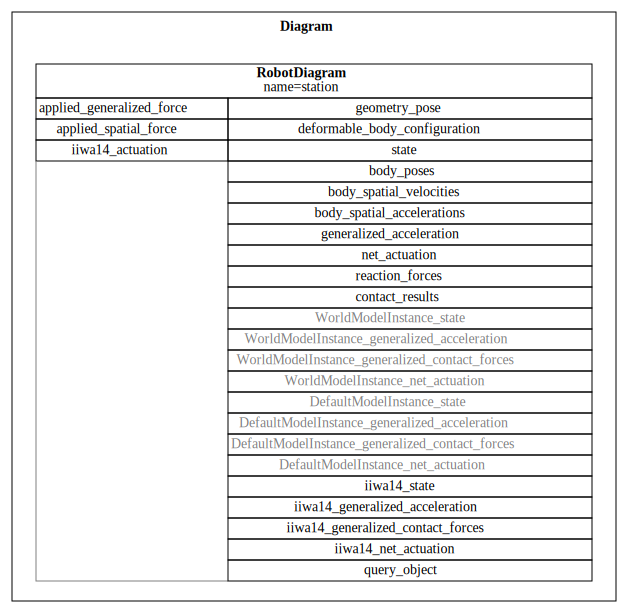

In [5]:
diagram = create_IIWA14_with_hardware_station()
RenderDiagram(diagram, max_depth=1)

In [6]:
print(f"请在 Meshcat 窗口（{meshcat.web_url()}）查看机器人仿真！")

# 也可以仿真简单的 IIWA14 场景，确保一切正常！
# TODO：为 diagram 创建 context
context = diagram.CreateDefaultContext()

# TODO：创建仿真器
simulator = Simulator(diagram, context)

# TODO：设置实时速率为 1.0
simulator.set_target_realtime_rate(1.0)

# TODO：仿真 15 秒
simulator.AdvanceTo(15.0)

请在 Meshcat 窗口（http://localhost:7000）查看机器人仿真！


---

## 第二部分：双臂 IIWA 场景

很好！为了展示 scenario 指令修改场景的便捷性，让我们再加一个 IIWA14。

**你的任务：** 用 scenario 指令创建包含两个 IIWA14 机器人、分别焊接在不同位置的场景。

**核心概念：** scenario 文件让你只需几行代码就能灵活修改场景——添加机器人、变更位置、调整配置都很方便。

**参考：** 推荐先阅读 [Bimanual Manipulation Example](https://deepnote.com/workspace/Manipulation-ac8201a1-470a-4c77-afd0-2cc45bc229ff/project/8f86172b-b597-4ceb-9bad-92d11ac7a6cc/notebook/bimanual-3df3abe2b1b949eb9daaf3748b16a218) 了解 scenario 指令和上述函数的用法。

In [7]:
def create_bimanual_IIWA14_with_hardware_station() -> Diagram:
    # TODO：编写加载两个 IIWA14 机器人的 scenario 字符串。
    # TODO：记得把两个机器人焊接到世界坐标系的不同位置！

    # TODO：添加左臂 IIWA14 机器人模型
    # TODO：设置默认关节位置
    # TODO：焊接机器人基座到世界坐标系
    # TODO：添加右臂 IIWA14 机器人模型
    # TODO：设置默认关节位置
    # TODO：焊接机器人基座到世界坐标系
    scenario_string = """directives:
- add_model:
    name: iiwa14_left
    file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
        iiwa_joint_1: [0.0]
        iiwa_joint_2: [0.3]
        iiwa_joint_3: [0.0]
        iiwa_joint_4: [-1.5]
        iiwa_joint_5: [0.0]
        iiwa_joint_6: [1.8]
        iiwa_joint_7: [0.0]
- add_weld:
    parent: world
    child: iiwa14_left::iiwa_link_0
    X_PC:
        translation: [0, 0.5, 0]
        rotation: !Rpy { deg: [0, 0, 0] }
- add_model:
    name: iiwa14_right
    file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
        iiwa_joint_1: [0.0]
        iiwa_joint_2: [0.3]
        iiwa_joint_3: [0.0]
        iiwa_joint_4: [-1.5]
        iiwa_joint_5: [0.0]
        iiwa_joint_6: [1.8]
        iiwa_joint_7: [0.0]
- add_weld:
    parent: world
    child: iiwa14_right::iiwa_link_0
    X_PC:
        translation: [0, -0.5, 0]
        rotation: !Rpy { deg: [0, 0, 0] }
"""

    # TODO：用字符串加载 scenario
    scenario = LoadScenario(data=scenario_string)

    # TODO：用 meshcat 创建 HardwareStation
    station = MakeHardwareStation(scenario, meshcat)

    # TODO：创建 DiagramBuilder，添加 station，build diagram
    builder = DiagramBuilder()
    builder.AddSystem(station)
    diagram = builder.Build()

    # TODO：返回 diagram
    return diagram


diagram = create_bimanual_IIWA14_with_hardware_station()

In [8]:
# Use this to test your implementation if you want!
Grader.grade_output([TestHardwareStationBimanual], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 10/10.

Score for Test bimanual IIWA14 HardwareStation creation and structure is 10/10.


接下来仿真该场景，确保一切正常：

In [9]:
print(f"请在 Meshcat 窗口（{meshcat.web_url()}）查看机器人仿真！")

# 也可以仿真简单的 IIWA14 场景，确保一切正常！
# TODO：为 station 创建 context
context = diagram.CreateDefaultContext()

# TODO：创建仿真器
simulator = Simulator(diagram, context)

# TODO：设置实时速率为 1.0
simulator.set_target_realtime_rate(1.0)

# TODO：仿真 15 秒
simulator.AdvanceTo(15.0)

请在 Meshcat 窗口（http://localhost:7000）查看机器人仿真！


---

## 第三部分：用 scenario 文件和模型指令加载自定义资产

现在学习如何用 scenario 文件加载自定义资产！我们将创建 YAML 场景文件，引用你的自定义模型并加载到 `HardwareStation`。

**你的任务：** 从零创建 scenario 文件，并用模型指令加载你的自定义资产。

**目标：** 导出包含双臂 IIWA14 和自定义资产的仿真视频，上传到 Gradescope。

**参考：** 推荐先阅读 [Bimanual Manipulation Example](https://deepnote.com/workspace/Manipulation-ac8201a1-470a-4c77-afd0-2cc45bc229ff/project/8f86172b-b597-4ceb-9bad-92d11ac7a6cc/notebook/bimanual-3df3abe2b1b949eb9daaf3748b16a218) 了解 scenario 指令和上述函数的用法。

首先确保你的字母资产已生成在正确的文件夹。运行下方代码，自由调整字母属性！

In [10]:
# Let us save our files to a new folder called `assets` in the `Files`
# section on the left
output_dir = Path("assets/")

# TODO: Insert your initials here!
your_initials = "BPG"

for letter in your_initials:
    create_sdf_asset_from_letter(
        text=letter,
        font_name="DejaVu Sans",
        letter_height_meters=0.2,
        extrusion_depth_meters=0.07,
        output_dir=output_dir / f"{letter}_model",
    )

`triangulate_polygon(*args, engine="triangle")`
to use the non-FSF-approved-license triangle engine
ERROR:root:Error creating SDF asset for letter 'B': No available triangulation engine!
`triangulate_polygon(*args, engine="triangle")`
to use the non-FSF-approved-license triangle engine
ERROR:root:Error creating SDF asset for letter 'P': No available triangulation engine!
`triangulate_polygon(*args, engine="triangle")`
to use the non-FSF-approved-license triangle engine
ERROR:root:Error creating SDF asset for letter 'G': No available triangulation engine!
ERROR:root:Error creating SDF asset for letter 'B': No available triangulation engine!
`triangulate_polygon(*args, engine="triangle")`
to use the non-FSF-approved-license triangle engine
ERROR:root:Error creating SDF asset for letter 'P': No available triangulation engine!
`triangulate_polygon(*args, engine="triangle")`
to use the non-FSF-approved-license triangle engine
ERROR:root:Error creating SDF asset for letter 'G': No available 

In order to load assets using the model directives we need to have them as local files. Let us save our table asset from the previous notebook to a local file. Fill out the missing code below:

In [17]:
# TODO：将你在笔记本2中写的 table_sdf = ... 代码粘贴到这里
table_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="table">
    <static>true</static>
    <link name="table_link">
      <visual name="table_visual">
        <geometry>
          <box>
            <size>1.2 0.8 0.05</size>
          </box>
        </geometry>
        <material>
          <diffuse>0.8 0.6 0.4 1.0</diffuse>
        </material>
      </visual>
      <collision name="table_collision">
        <geometry>
          <box>
            <size>1.2 0.8 0.05</size>
          </box>
        </geometry>
      </collision>
      <inertial>
        <mass>10.0</mass>
        <inertia>
          <ixx>0.83</ixx>
          <iyy>1.83</iyy>
          <izz>2.5</izz>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyz>0</iyz>
        </inertia>
      </inertial>
    </link>
    <!-- 添加桌腿 -->
    <link name="leg1">
      <pose>0.55 0.35 -0.375 0 0 0</pose>
      <visual name="leg1_visual">
        <geometry>
          <cylinder>
            <radius>0.025</radius>
            <length>0.75</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>0.6 0.4 0.2 1.0</diffuse>
        </material>
      </visual>
      <collision name="leg1_collision">
        <geometry>
          <cylinder>
            <radius>0.025</radius>
            <length>0.75</length>
          </cylinder>
        </geometry>
      </collision>
    </link>
    <link name="leg2">
      <pose>0.55 -0.35 -0.375 0 0 0</pose>
      <visual name="leg2_visual">
        <geometry>
          <cylinder>
            <radius>0.025</radius>
            <length>0.75</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>0.6 0.4 0.2 1.0</diffuse>
        </material>
      </visual>
      <collision name="leg2_collision">
        <geometry>
          <cylinder>
            <radius>0.025</radius>
            <length>0.75</length>
          </cylinder>
        </geometry>
      </collision>
    </link>
    <link name="leg3">
      <pose>-0.55 0.35 -0.375 0 0 0</pose>
      <visual name="leg3_visual">
        <geometry>
          <cylinder>
            <radius>0.025</radius>
            <length>0.75</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>0.6 0.4 0.2 1.0</diffuse>
        </material>
      </visual>
      <collision name="leg3_collision">
        <geometry>
          <cylinder>
            <radius>0.025</radius>
            <length>0.75</length>
          </cylinder>
        </geometry>
      </collision>
    </link>
    <link name="leg4">
      <pose>-0.55 -0.35 -0.375 0 0 0</pose>
      <visual name="leg4_visual">
        <geometry>
          <cylinder>
            <radius>0.025</radius>
            <length>0.75</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>0.6 0.4 0.2 1.0</diffuse>
        </material>
      </visual>
      <collision name="leg4_collision">
        <geometry>
          <cylinder>
            <radius>0.025</radius>
            <length>0.75</length>
          </cylinder>
        </geometry>
      </collision>
    </link>
    <!-- 将桌腿连接到桌面 -->
    <joint name="leg1_joint" type="fixed">
      <parent>table_link</parent>
      <child>leg1</child>
    </joint>
    <joint name="leg2_joint" type="fixed">
      <parent>table_link</parent>
      <child>leg2</child>
    </joint>
    <joint name="leg3_joint" type="fixed">
      <parent>table_link</parent>
      <child>leg3</child>
    </joint>
    <joint name="leg4_joint" type="fixed">
      <parent>table_link</parent>
      <child>leg4</child>
    </joint>
  </model>
</sdf>
"""

# TODO：将 table SDF 写入文件
table_sdf_path = "assets/table.sdf"
with open(table_sdf_path, "w") as f:
    f.write(table_sdf)

很好。现在我们可以像之前用 scenario 指令加载 IIWA14 一样加载自定义资产。要在 scenario 指令中访问本地文件，语法如下：
- `file://绝对路径/your/file.sdf`

例如，assets 文件夹下的字母 B，可以用如下 f-string：
- `f"file://{Path.cwd()}/assets/B_model/B.sdf"`

**注意**：资产路径必须为绝对路径，所以要用 `Path.cwd()` 获取当前工作目录！路径对空格和缩进很敏感，加载失败时请检查是否有多余空格。

我们要把桌子焊接到世界坐标系，防止其掉落。

还要为姓名首字母指定默认自由体位姿，格式如下（f-string 内）：
```
- add_model:
    name: {YOUR_OBJECT_NAME}
    file: {PATH_TO_OBJECT}
    default_free_body_pose:
        {BASE_LINK_NAME}:
            translation: [x_pos, y_pos, z_pos]
            rotation: !Rpy {{ deg: [x_rot, y_rot, z_rot] }}
```
请替换：
- `{YOUR_OBJECT_NAME}`：自定义名称
- `{PATH_TO_OBJECT}`：.sdf 或 .urdf 文件路径（本地或 drake-models 包路径均可）
- `{BASE_LINK_NAME}`：.sdf 或 .urdf 文件中的基座 link 名称。

例如字母 B，可写为：

```
- add_model:
    name: B_letter
    file: file://{Path.cwd()/assets/B_model.sdf}
    default_free_body_pose:
        B_body_link:
            translation: [0, 1.0, 0.75]
            rotation: !Rpy {{ deg: [42, 33, 18] }}
```

此外，还可以加载 [drake-models](https://github.com/RobotLocomotion/models) 中的物体，
同样作为自由体（如 [这些物体](https://github.com/RobotLocomotion/models/tree/master/ycb)）。

**总结：你需要实现的场景包括：**
- 加载两个 Kuka IIWA14 机器人，设置默认关节位置，焊接到世界坐标系
- 加载本地 .sdf 文件的桌子，并焊接到世界坐标系
- 加载本地 .sdf 文件的姓名首字母，设置默认自由体位姿
- 加载一个或多个 drake-models 物体，设置默认自由体位姿

In [18]:
def create_bimanual_IIWA14_with_table_and_initials_and_assets() -> (
    tuple[Diagram, RobotDiagram]
):
    # TODO：编写包含以下内容的 scenario YAML 字符串：
    #       - IIWA14 机器人及默认关节位置
    #       - 焊接机器人到世界坐标系
    #       - 用 file://绝对路径/table.sdf 加载桌子
    #       - 焊接桌子并设置平移偏移
    #       - 用 file://绝对路径/B_model/B.sdf 加载姓名首字母
    #       - 加载 drake-models 中的物体，作为自由体
    scenario_yaml = f"""directives:
# 添加左臂 IIWA14 机器人
- add_model:
    name: iiwa14_left
    file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
        iiwa_joint_1: [0.0]
        iiwa_joint_2: [0.3]
        iiwa_joint_3: [0.0]
        iiwa_joint_4: [-1.5]
        iiwa_joint_5: [0.0]
        iiwa_joint_6: [1.8]
        iiwa_joint_7: [0.0]
# 焊接左臂到世界坐标系
- add_weld:
    parent: world
    child: iiwa14_left::iiwa_link_0
    X_PC:
        translation: [0, 0.5, 0.75]
        rotation: !Rpy {{ deg: [0, 0, 0] }}
# 添加右臂 IIWA14 机器人
- add_model:
    name: iiwa14_right
    file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
        iiwa_joint_1: [0.0]
        iiwa_joint_2: [0.3]
        iiwa_joint_3: [0.0]
        iiwa_joint_4: [-1.5]
        iiwa_joint_5: [0.0]
        iiwa_joint_6: [1.8]
        iiwa_joint_7: [0.0]
# 焊接右臂到世界坐标系
- add_weld:
    parent: world
    child: iiwa14_right::iiwa_link_0
    X_PC:
        translation: [0, -0.5, 0.75]
        rotation: !Rpy {{ deg: [0, 0, 0] }}
# 添加桌子（静态模型会自动焊接到世界坐标系原点）
- add_model:
    name: table
    file: file://{Path.cwd()}/assets/table.sdf
# 添加字母 B
- add_model:
    name: letter_B
    file: file://{Path.cwd()}/assets/B_model/B.sdf
    default_free_body_pose:
        B_body_link:
            translation: [0.7, 0.0, 1.0]
            rotation: !Rpy {{ deg: [0, 0, 0] }}
# 添加字母 P
- add_model:
    name: letter_P
    file: file://{Path.cwd()}/assets/P_model/P.sdf
    default_free_body_pose:
        P_body_link:
            translation: [0.9, 0.0, 1.0]
            rotation: !Rpy {{ deg: [0, 0, 0] }}
# 添加字母 G
- add_model:
    name: letter_G
    file: file://{Path.cwd()}/assets/G_model/G.sdf
    default_free_body_pose:
        G_body_link:
            translation: [1.1, 0.0, 1.0]
            rotation: !Rpy {{ deg: [0, 0, 0] }}
# 添加一个 YCB 物体（香蕉）
- add_model:
    name: banana
    file: package://drake_models/ycb/011_banana.sdf
    default_free_body_pose:
        base_link:
            translation: [0.5, 0.0, 0.8]
            rotation: !Rpy {{ deg: [0, 0, 45] }}
"""

    # TODO：将 scenario YAML 保存到文件
    scenario_file_path = "scenario.yaml"
    with open(scenario_file_path, "w") as f:
        f.write(scenario_yaml)

    # TODO：从文件加载 scenario
    scenario = LoadScenario(filename=scenario_file_path)

    # TODO：用 scenario 和 meshcat 创建 HardwareStation
    station = MakeHardwareStation(scenario, meshcat)

    # TODO：创建 DiagramBuilder，添加 station，build diagram
    builder = DiagramBuilder()
    builder.AddSystem(station)
    diagram = builder.Build()

    # TODO：返回 diagram 和 station（注意这里需要都返回）
    return diagram, station

让我们可视化模块图：

In [19]:
diagram, station = create_bimanual_IIWA14_with_table_and_initials_and_assets()
RenderDiagram(diagram, max_depth=1)

RuntimeError: error: URI 'file:///mnt/c/Users/lvxiangyu11/code/drake/robotic_manipulation/0_introduction/assets/B_model/B.sdf' resolved to '/mnt/c/Users/lvxiangyu11/code/drake/robotic_manipulation/0_introduction/assets/B_model/B.sdf' which does not exist.

让我们快速仿真，体验 HardwareStation 的效果：


In [20]:
# TODO：仿真 HardwareStation


def simulate_full_system(
    iiwa_left_q0: np.ndarray,
    iiwa_right_q0: np.ndarray,
    letter_poses: list[RigidTransform],
    object_poses: list[RigidTransform],
    simulation_time: float = 3.0,
    use_realtime: bool = True,
) -> None:
    # TODO：用你上面实现的函数创建 diagram 和 station
    diagram, station = create_bimanual_IIWA14_with_table_and_initials_and_assets()

    # TODO：创建仿真器和可变仿真 context
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # TODO：从 station 获取 plant 子系统
    plant = station.GetSubsystemByName("plant")

    # TODO：用 root context 获取 plant context
    context_plant = plant.GetMyMutableContextFromRoot(context)

    # NOTE：下面我们将设置机器人和资产的初始配置。
    #       实际上 scenario 文件里已经设置了，这里只是演示如何在加载后修改。

    # TODO：设置左臂 IIWA 机器人初始配置
    # TODO：用名称获取左臂 IIWA 模型实例
    # 提示：名称即 add_model 指令里的 `name` 字段
    # 提示：一定要用 plant context 而不是 root context！
    iiwa_left_model = plant.GetModelInstanceByName("iiwa14_left")
    plant.SetPositions(context_plant, iiwa_left_model, iiwa_left_q0)

    # TODO：设置右臂 IIWA 机器人初始配置
    # TODO：用名称获取右臂 IIWA 模型实例
    iiwa_right_model = plant.GetModelInstanceByName("iiwa14_right")
    plant.SetPositions(context_plant, iiwa_right_model, iiwa_right_q0)

    # TODO：设置姓名首字母的初始位姿
    # 提示：先用名称获取模型实例，再用 RigidBody 名称（如 `B_body_link`，SDF 文件中硬编码）
    #       plant.SetFreeBodyPose(context_plant, body, letter_poses[0])
    
    # 设置字母 B 的位姿
    letter_B_model = plant.GetModelInstanceByName("letter_B")
    letter_B_body = plant.GetBodyByName("B_body_link", letter_B_model)
    plant.SetFreeBodyPose(context_plant, letter_B_body, letter_poses[0])
    
    # 设置字母 P 的位姿
    letter_P_model = plant.GetModelInstanceByName("letter_P")
    letter_P_body = plant.GetBodyByName("P_body_link", letter_P_model)
    plant.SetFreeBodyPose(context_plant, letter_P_body, letter_poses[1])
    
    # 设置字母 G 的位姿
    letter_G_model = plant.GetModelInstanceByName("letter_G")
    letter_G_body = plant.GetBodyByName("G_body_link", letter_G_model)
    plant.SetFreeBodyPose(context_plant, letter_G_body, letter_poses[2])
    
    # 设置香蕉的位姿
    banana_model = plant.GetModelInstanceByName("banana")
    banana_body = plant.GetBodyByName("base_link", banana_model)
    plant.SetFreeBodyPose(context_plant, banana_body, object_poses[0])

    # TODO：配置仿真器为实时速率
    if use_realtime:
        simulator.set_target_realtime_rate(1.0)

    # TODO：运行仿真
    simulator.AdvanceTo(simulation_time)

In [21]:
# Test your simulation
print(f"Check your Meshcat window ({meshcat.web_url()}) to see the robot simulation!")
print("Running HardwareStation simulation...")

meshcat.StartRecording()
simulate_full_system(
    iiwa_left_q0=np.array([0, 0, 0, 0, 0, 0, 0]),
    iiwa_right_q0=np.array([0, 0, 0, 0, 0, 0, 0]),
    # NOTE: Here we have provided the initial poses for three letters, and one object, as
    # an example. Change these to match your setup!
    letter_poses=[
        # You can add rotations to the RigidTransform if you want, but we will learn more about that later!
        # The letters should be placed such that they are not in collision with each other, and such that
        # they fall onto the table.
        RigidTransform([0.7, 0.0, 1.0]),
        RigidTransform([0.9, 0.0, 1.0]),
        RigidTransform([1.1, 0.0, 1.0]),
    ],
    object_poses=[
        RigidTransform([0.5, 0.0, 0.75]),
    ],
    simulation_time=5.0 if running_as_notebook else 5.0,
    use_realtime=running_as_notebook,
)
meshcat.StopRecording()
meshcat.PublishRecording()

print("HardwareStation simulation completed!")

Check your Meshcat window (http://localhost:7000) to see the robot simulation!
Running HardwareStation simulation...


RuntimeError: error: URI 'file:///mnt/c/Users/lvxiangyu11/code/drake/robotic_manipulation/0_introduction/assets/B_model/B.sdf' resolved to '/mnt/c/Users/lvxiangyu11/code/drake/robotic_manipulation/0_introduction/assets/B_model/B.sdf' which does not exist.

---

# 恭喜你！

你已成功完成 **HardwareStation 与进阶场景** 笔记本！你学到了：

- **HardwareStation** —— 自动化复杂机器人搭建的高级工具
- **Scenario 文件** —— 基于 YAML 的声明式场景配置
- **自定义资产** —— 将你自己的模型加载到场景中

---

# GRADESCOPE 验证
恭喜你！本笔记本全部完成。现在在浏览器中回放仿真并将录屏上传到 Gradescope。
